# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=70,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 65)
OOV context shape: (16562, 28)
Right context shape: (16562, 68)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[-8.5925378e-11,  4.5763605e-41, -8.5925378e-11, ...,
         4.5763605e-41,  3.5532771e-21,  4.5763605e-41],
       [ 1.1265459e-40,  0.0000000e+00,  3.0430165e-20, ...,
         0.0000000e+00,  3.0431199e-20,  4.5763605e-41],
       [ 3.5535873e-21,  4.5763605e-41,  1.1267000e-40, ...,
         4.5763605e-41,  1.1268401e-40,  0.0000000e+00],
       ...,
       [ 1.0994448e-40,  0.0000000e+00,  2.6582128e-21, ...,
         0.0000000e+00,  2.6582774e-21,  4.5763605e-41],
       [ 3.5040857e-21,  4.5763605e-41,  1.0995989e-40, ...,
         4.5763605e-41,  1.0997390e-40,  0.0000000e+00],
       [ 2.6583485e-21,  4.5763605e-41,  3.5043701e-21, ...,
         4.5763605e-41,  3.5046285e-21,  4.5763605e-41]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=5.9626 | F1Score=0.2888
Batch-100: NLLLoss=4.7250 | F1Score=0.3044
Batch-150: NLLLoss=5.9060 | F1Score=0.3176
Batch-200: NLLLoss=2.8798 | F1Score=0.3411
Batch-250: NLLLoss=4.0345 | F1Score=0.3527
Batch-300: NLLLoss=4.3362 | F1Score=0.3745
Batch-350: NLLLoss=4.9097 | F1Score=0.3868
Batch-400: NLLLoss=3.1116 | F1Score=0.4007
Batch-450: NLLLoss=3.7858 | F1Score=0.4154
Batch-500: NLLLoss=3.7133 | F1Score=0.4265
Batch-518: NLLLoss=2.9188 | F1Score=0.4316

Mean NLLLoss: 4.5346 | Mean F1Score: 0.3515

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.5968 | F1Score=0.5658
Batch-100: NLLLoss=3.0534 | F1Score=0.5846
Batch-150: NLLLoss=3.7616 | F1Score=0.5914
Batch-200: NLLLoss=4.1978 | F1Score=0.5974
Batch-250: NLLLoss=2.1446 | F1Score=0.6053
Batch-300: NLLLoss=3.3228 | F1Score=0.6111
Batch-350: NLLLoss=2.6238 | F1Score=0.6195
Batch-400: NLLLoss=3.1342 | F1Score=0.6204
Batch-450: NLLLoss=3.2092 | F1Score=0.6261
Batch-500: NLLLoss=1.7970 | F1Score=0.6306
Batch-518: NLLLoss=3.1688 | F1Score=0.6328

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.7275 | Mean F1Score: 0.6025

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.2814 | F1Score=0.7300
Batch-100: NLLLoss=1.3455 | F1Score=0.7300
Batch-150: NLLLoss=2.0479 | F1Score=0.7243
Batch-200: NLLLoss=1.6524 | F1Score=0.7209
Batch-250: NLLLoss=1.4019 | F1Score=0.7230
Batch-300: NLLLoss=1.7378 | F1Score=0.7301
Batch-350: NLLLoss=2.3604 | F1Score=0.7310
Batch-400: NLLLoss=2.7076 | F1Score=0.7368
Batch-450: NLLLoss=1.4116 | F1Score=0.7405
Batch-500: NLLLoss=2.1996 | F1Score=0.7429
Batch-518: NLLLoss=1.3633 | F1Score=0.7444

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7968 | Mean F1Score: 0.7311

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.8774 | F1Score=0.8096
Batch-100: NLLLoss=1.0098 | F1Score=0.8111
Batch-150: NLLLoss=0.9803 | F1Score=0.8172
Batch-200: NLLLoss=1.7663 | F1Score=0.8154
Batch-250: NLLLoss=0.9683 | F1Score=0.8108
Batch-300: NLLLoss=1.3250 | F1Score=0.8116
Batch-350: NLLLoss=0.6573 | F1Score=0.8116
Batch-400: NLLLoss=1.0251 | F1Score=0.8133
Batch-450: NLLLoss=0.8068 | F1Score=0.8129
Batch-500: NLLLoss=1.5752 | F1Score=0.8155
Batch-518: NLLLoss=1.1776 | F1Score=0.8157

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1748 | Mean F1Score: 0.8138

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.4882 | F1Score=0.8853
Batch-100: NLLLoss=1.0238 | F1Score=0.8873
Batch-150: NLLLoss=0.4002 | F1Score=0.8870
Batch-200: NLLLoss=0.5830 | F1Score=0.8843
Batch-250: NLLLoss=0.1815 | F1Score=0.8813
Batch-300: NLLLoss=0.8239 | F1Score=0.8795
Batch-350: NLLLoss=0.6210 | F1Score=0.8785
Batch-400: NLLLoss=0.5364 | F1Score=0.8751
Batch-450: NLLLoss=0.6446 | F1Score=0.8733
Batch-500: NLLLoss=1.3465 | F1Score=0.8724
Batch-518: NLLLoss=0.4671 | F1Score=0.8717

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.7033 | Mean F1Score: 0.8801

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.3053 | F1Score=0.9569
Batch-100: NLLLoss=0.4790 | F1Score=0.9506
Batch-150: NLLLoss=0.2583 | F1Score=0.9488
Batch-200: NLLLoss=0.4055 | F1Score=0.9470
Batch-250: NLLLoss=0.2226 | F1Score=0.9461
Batch-300: NLLLoss=0.2738 | F1Score=0.9432
Batch-350: NLLLoss=0.2780 | F1Score=0.9413
Batch-400: NLLLoss=0.5942 | F1Score=0.9396
Batch-450: NLLLoss=0.6006 | F1Score=0.9386
Batch-500: NLLLoss=0.1123 | F1Score=0.9374
Batch-518: NLLLoss=0.1956 | F1Score=0.9370

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3452 | Mean F1Score: 0.9458

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0852 | F1Score=0.9931
Batch-100: NLLLoss=0.1307 | F1Score=0.9903
Batch-150: NLLLoss=0.2328 | F1Score=0.9898
Batch-200: NLLLoss=0.0761 | F1Score=0.9903
Batch-250: NLLLoss=0.1801 | F1Score=0.9889
Batch-300: NLLLoss=0.2080 | F1Score=0.9884
Batch-350: NLLLoss=0.1787 | F1Score=0.9878
Batch-400: NLLLoss=0.1492 | F1Score=0.9879
Batch-450: NLLLoss=0.1452 | F1Score=0.9872
Batch-500: NLLLoss=0.0827 | F1Score=0.9871
Batch-518: NLLLoss=0.1367 | F1Score=0.9869

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1171 | Mean F1Score: 0.9894

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0311 | F1Score=0.9981
Batch-100: NLLLoss=0.0557 | F1Score=0.9991
Batch-150: NLLLoss=0.0135 | F1Score=0.9987
Batch-200: NLLLoss=0.0129 | F1Score=0.9989
Batch-250: NLLLoss=0.0274 | F1Score=0.9991
Batch-300: NLLLoss=0.0295 | F1Score=0.9988
Batch-350: NLLLoss=0.0196 | F1Score=0.9987
Batch-400: NLLLoss=0.0498 | F1Score=0.9988
Batch-450: NLLLoss=0.0414 | F1Score=0.9987
Batch-500: NLLLoss=0.0483 | F1Score=0.9987
Batch-518: NLLLoss=0.0476 | F1Score=0.9986

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0341 | Mean F1Score: 0.9988

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0118 | F1Score=0.9997
Batch-100: NLLLoss=0.0292 | F1Score=0.9997
Batch-150: NLLLoss=0.0172 | F1Score=0.9998
Batch-200: NLLLoss=0.0070 | F1Score=0.9997
Batch-250: NLLLoss=0.0084 | F1Score=0.9997
Batch-300: NLLLoss=0.0248 | F1Score=0.9995
Batch-350: NLLLoss=0.0045 | F1Score=0.9995
Batch-400: NLLLoss=0.0123 | F1Score=0.9995
Batch-450: NLLLoss=0.0125 | F1Score=0.9994
Batch-500: NLLLoss=0.0044 | F1Score=0.9995
Batch-518: NLLLoss=0.0046 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0125 | Mean F1Score: 0.9996

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0270 | F1Score=0.9997
Batch-100: NLLLoss=0.0053 | F1Score=0.9998
Batch-150: NLLLoss=0.0036 | F1Score=0.9997
Batch-200: NLLLoss=0.0041 | F1Score=0.9996
Batch-250: NLLLoss=0.0071 | F1Score=0.9994
Batch-300: NLLLoss=0.0088 | F1Score=0.9993
Batch-350: NLLLoss=0.0085 | F1Score=0.9994
Batch-400: NLLLoss=0.0100 | F1Score=0.9995
Batch-450: NLLLoss=0.0075 | F1Score=0.9994
Batch-500: NLLLoss=0.0041 | F1Score=0.9994
Batch-518: NLLLoss=0.0082 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0084 | Mean F1Score: 0.9996

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0051 | F1Score=0.9997
Batch-100: NLLLoss=0.0018 | F1Score=0.9998
Batch-150: NLLLoss=0.0053 | F1Score=0.9999
Batch-200: NLLLoss=0.0046 | F1Score=0.9999
Batch-250: NLLLoss=0.0031 | F1Score=0.9999
Batch-300: NLLLoss=0.0046 | F1Score=0.9999
Batch-350: NLLLoss=0.0166 | F1Score=0.9997
Batch-400: NLLLoss=0.0130 | F1Score=0.9995
Batch-450: NLLLoss=0.0048 | F1Score=0.9995
Batch-500: NLLLoss=0.0034 | F1Score=0.9996
Batch-518: NLLLoss=0.0056 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0078 | Mean F1Score: 0.9998

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0056 | F1Score=0.9994
Batch-100: NLLLoss=0.0099 | F1Score=0.9987
Batch-150: NLLLoss=0.1428 | F1Score=0.9946
Batch-200: NLLLoss=0.6221 | F1Score=0.9731
Batch-250: NLLLoss=0.2044 | F1Score=0.9625
Batch-300: NLLLoss=0.2808 | F1Score=0.9586
Batch-350: NLLLoss=0.1051 | F1Score=0.9563
Batch-400: NLLLoss=0.1113 | F1Score=0.9557
Batch-450: NLLLoss=0.0915 | F1Score=0.9574
Batch-500: NLLLoss=0.1041 | F1Score=0.9586
Batch-518: NLLLoss=0.1985 | F1Score=0.9586

Huft 😥! Model not improved.
Mean NLLLoss: 0.1768 | Mean F1Score: 0.9731
Patience = 1/20❗

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0071 | F1Score=0.9862
Batch-100: NLLLoss=0.0361 | F1Score=0.9862
Batch-150: NLLLoss=0.0469 | F1Score=0.9886
Batch-200: NLLLoss=0.0132 | F1Score=0.9891
Batch-250: NLLLoss=0.0051 | F1Score=0.9904
Batch-300: NLLLoss=0.0053 | F1Score=0.9911
Batch-350: NLLLoss=0.0125 | F1Score=0.9916
Batch-400: NLLLoss=0.0716 | F1Score=0.9922
Batch-450: NLLLoss=0.0183 | F1Score=0.9919
Batch-500: NLLLoss=0.0303 | F1Score=0.9922
Batch-518: NLLLoss=0.0633 | F1Score=0.9922

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0440 | Mean F1Score: 0.9898

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0016 | F1Score=0.9994
Batch-100: NLLLoss=0.0054 | F1Score=0.9997
Batch-150: NLLLoss=0.0038 | F1Score=0.9998
Batch-200: NLLLoss=0.0016 | F1Score=0.9998
Batch-250: NLLLoss=0.0053 | F1Score=0.9998
Batch-300: NLLLoss=0.0048 | F1Score=0.9998
Batch-350: NLLLoss=0.0018 | F1Score=0.9998
Batch-400: NLLLoss=0.0025 | F1Score=0.9998
Batch-450: NLLLoss=0.0027 | F1Score=0.9996
Batch-500: NLLLoss=0.0056 | F1Score=0.9996
Batch-518: NLLLoss=0.0045 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0061 | Mean F1Score: 0.9997

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0025 | F1Score=1.0000
Batch-100: NLLLoss=0.0014 | F1Score=1.0000
Batch-150: NLLLoss=0.0008 | F1Score=1.0000
Batch-200: NLLLoss=0.0019 | F1Score=1.0000
Batch-250: NLLLoss=0.0020 | F1Score=0.9999
Batch-300: NLLLoss=0.0018 | F1Score=0.9998
Batch-350: NLLLoss=0.0015 | F1Score=0.9997
Batch-400: NLLLoss=0.0010 | F1Score=0.9996
Batch-450: NLLLoss=0.0007 | F1Score=0.9997
Batch-500: NLLLoss=0.0013 | F1Score=0.9997
Batch-518: NLLLoss=0.0024 | F1Score=0.9997

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0022 | Mean F1Score: 0.9998

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0009 | F1Score=1.0000
Batch-100: NLLLoss=0.0012 | F1Score=1.0000
Batch-150: NLLLoss=0.0007 | F1Score=1.0000
Batch-200: NLLLoss=0.0022 | F1Score=0.9998
Batch-250: NLLLoss=0.0009 | F1Score=0.9998
Batch-300: NLLLoss=0.0007 | F1Score=0.9997
Batch-350: NLLLoss=0.0007 | F1Score=0.9997
Batch-400: NLLLoss=0.0011 | F1Score=0.9997
Batch-450: NLLLoss=0.0017 | F1Score=0.9998
Batch-500: NLLLoss=0.0018 | F1Score=0.9997
Batch-518: NLLLoss=0.0009 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0018 | Mean F1Score: 0.9998

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0008 | F1Score=1.0000
Batch-100: NLLLoss=0.0006 | F1Score=1.0000
Batch-150: NLLLoss=0.0686 | F1Score=0.9997
Batch-200: NLLLoss=0.0005 | F1Score=0.9998
Batch-250: NLLLoss=0.0005 | F1Score=0.9998
Batch-300: NLLLoss=0.0016 | F1Score=0.9996
Batch-350: NLLLoss=0.0014 | F1Score=0.9993
Batch-400: NLLLoss=0.0037 | F1Score=0.9987
Batch-450: NLLLoss=0.0227 | F1Score=0.9973
Batch-500: NLLLoss=0.2186 | F1Score=0.9960
Batch-518: NLLLoss=0.0206 | F1Score=0.9957

Huft 😥! Model not improved.
Mean NLLLoss: 0.0206 | Mean F1Score: 0.9991
Patience = 2/20❗

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0778 | F1Score=0.9875
Batch-100: NLLLoss=0.3295 | F1Score=0.9853
Batch-150: NLLLoss=0.0494 | F1Score=0.9843
Batch-200: NLLLoss=0.3279 | F1Score=0.9820
Batch-250: NLLLoss=0.2062 | F1Score=0.9796
Batch-300: NLLLoss=0.0441 | F1Score=0.9793
Batch-350: NLLLoss=0.2688 | F1Score=0.9787
Batch-400: NLLLoss=0.0784 | F1Score=0.9790
Batch-450: NLLLoss=0.0086 | F1Score=0.9793
Batch-500: NLLLoss=0.0295 | F1Score=0.9799
Batch-518: NLLLoss=0.2217 | F1Score=0.9801

Huft 😥! Model not improved.
Mean NLLLoss: 0.0801 | Mean F1Score: 0.9818
Patience = 3/20❗

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0314 | F1Score=0.9984
Batch-100: NLLLoss=0.0086 | F1Score=0.9977
Batch-150: NLLLoss=0.0072 | F1Score=0.9970
Batch-200: NLLLoss=0.0038 | F1Score=0.9973
Batch-250: NLLLoss=0.0354 | F1Score=0.9977
Batch-300: NLLLoss=0.0099 | F1Score=0.9979
Batch-350: NLLLoss=0.0010 | F1Score=0.9980
Batch-400: NLLLoss=0.0068 | F1Score=0.9979
Batch-450: NLLLoss=0.0012 | F1Score=0.9979
Batch-500: NLLLoss=0.0177 | F1Score=0.9981
Batch-518: NLLLoss=0.0004 | F1Score=0.9981

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0132 | Mean F1Score: 0.9978

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0015 | F1Score=1.0000
Batch-100: NLLLoss=0.0005 | F1Score=1.0000
Batch-150: NLLLoss=0.0004 | F1Score=1.0000
Batch-200: NLLLoss=0.0004 | F1Score=0.9999
Batch-250: NLLLoss=0.0002 | F1Score=0.9999
Batch-300: NLLLoss=0.0004 | F1Score=0.9999
Batch-350: NLLLoss=0.0016 | F1Score=0.9999
Batch-400: NLLLoss=0.0017 | F1Score=0.9999
Batch-450: NLLLoss=0.0035 | F1Score=0.9999
Batch-500: NLLLoss=0.0010 | F1Score=0.9999
Batch-518: NLLLoss=0.0011 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0013 | Mean F1Score: 0.9999

TRAINING SUMMARY
Best NLLLoss      : 0.0013
Best F1Score      : 0.9999
Training duration : 31.798 minutes.
Training date     : 2022-10-11 18:03:50.490284+08:00


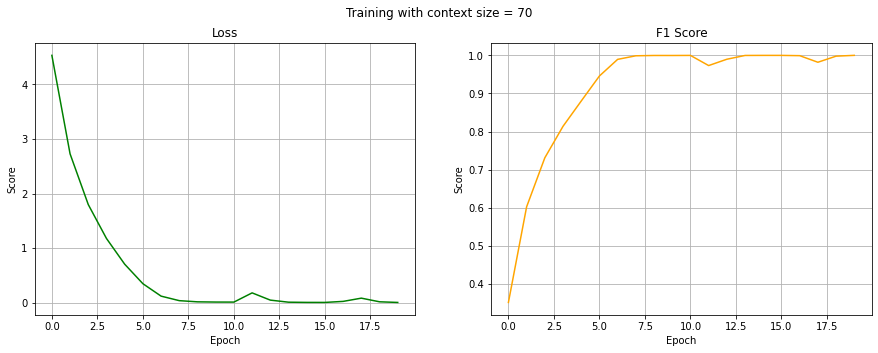

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[ 0.16818544,  2.1862051 ,  1.3241848 , ..., -0.3507055 ,
        -4.335224  , -3.066726  ],
       [ 6.412116  , -1.8693992 ,  3.9892633 , ..., -1.8746115 ,
         0.76640475,  8.432886  ],
       [ 6.1087055 ,  0.46522278, -1.8878435 , ..., -2.519249  ,
         2.4431005 ,  6.155076  ],
       ...,
       [ 0.40316278, -2.659848  , -4.500704  , ..., -9.384507  ,
         1.0302902 ,  1.4961867 ],
       [-3.481931  ,  7.5845604 , -0.9713888 , ..., -5.489715  ,
        -5.605214  , -1.0845299 ],
       [ 2.4219918 , -5.320081  , -2.748453  , ..., -3.3779361 ,
        -1.2179054 , -1.0573279 ]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[-0.1752, -0.2253,  0.2140,  ..., -0.3710,  0.2593, -0.0005],
                      [ 0.1128, -0.1407, -0.1047,  ..., -0.3076,  0.4449,  0.0471],
                      [ 0.0812,  0.1805,  0.2146,  ..., -0.1118,  0.0690, -0.4765],
                      ...,
                      [ 0.1076, -0.2078,  0.0775,  ..., -0.1524,  0.0861, -0.2193],
                      [ 0.4088, -0.1101, -0.4411,  ..., -0.0962,  0.2110,  0.1047],
                      [ 0.3475,  0.0076,  0.2233,  ..., -0.2455,  0.2049, -0.2490]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[-2.2124e-02, -1.1768e-01, -2.6057e-01,  ..., -2.0322e-01,
                       -2.1703e-02,  2.2001e-01],
                      [-4.1550e-02,  4.5393e-03,  8.8242e-03,  ..., -7.2486e-02,
                       -1.4707e-01,  1.3819e-02],
                      [-1.5200e-03,  7.4562e-02, -1.2125e-02,  ..., -1.8781e-01,
       